In [2]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler # Radial basis features

matplotlib.style.use('ggplot')

In [3]:
env = gym.envs.make("MountainCar-v0")

In [4]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
# print(observation_examples[:5]) # I assume its the position, velocity, reward, done, prob
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples) # will find the mean and std-deviation of observations given by mean_ and scale_

# Used to convert a state to a featurized representation.
# We use RBF kernels with different variances to cover different parts of the space
# Feature union applies fits X in parallel to all features and then concatenates the result
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))
# to actually transform the state x using these features you will use the transform function of scikit-learn

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [34]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = [] # separate model for each action what does this mean, and how will I scale for infinite action spaces
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant", max_iter=1000, tol=1e-4)
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model) # self.models contains model for each action
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        We will make use of Scale transform and RBF features computed above
        So each state is converted into 400 length vector
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        its like the second and third picture in David Silvers class
        if action is given it will give value of this state and this action
        else it will give value for all the action and we will use our
        self.model where we have one model per action
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        # TODO: Implement this!
        # given state predict the value of action a or all action, this boils down to doing forward pass through all the action model
        # first transform the state to feature space
        featurized_state = self.featurize_state(s)
        if a:
            val = self.models[a].predict(featurized_state.reshape(1,-1))[0]
            return val
        else:
            val = list()
            for m in self.models:
                val.append(m.predict(featurized_state.reshape(1,-1))[0])
            return np.asarray(val)
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        This amounts to making an update to the regressor model for the specified action.
        """
        # TODO: Implement this!
        featurized_state = self.featurize_state(s)
        featurized_state = featurized_state.reshape(1,-1)
        # apply the partial fit to the action value prediction model a
        self.models[a].partial_fit(featurized_state, [y])
        return None

In [35]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation) # since action is not specified this will return value of action at this state
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [36]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    TD control meaning target value we will use is r+discount_factor*max_a'(Q(s', a'))
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    off-policy meaning we will sample a' from different policy than we will use to obtain the next state.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        print("\rEpisode {}/{} ({})".format(i_episode + 1, num_episodes, last_reward), end="")
        sys.stdout.flush()
        
        # TODO: Implement this!
        observation = env.reset()
        ep_len = 0
        ep_reward = 0
        while True:
            # based on the observation get the action probabilities
            action_probs = policy(observation)
            # sample from these action probabilities
            action_ = np.random.choice(env.action_space.n, p=action_probs)
            
            # execute the action to get the next state, reward, done, prob
            next_state, reward, done, _ = env.step(action=action_)
            # now we will act greedily with respect to the current q-value function, i.e say that it should have predicted
            # q-value to be max of the action from the next state q-value row
            td_target = reward + discount_factor*np.max(estimator.predict(next_state)) # this will give you a target ...
            
            # now update the action-value function considering this as the target_value
            estimator.update(observation, action_, td_target)
            
            ep_len += 1
            ep_reward += reward
            if done:
                stats[0][i_episode] = ep_len                
                stats[1][i_episode] = ep_reward
                break
            observation = next_state
    
    return stats

In [45]:
estimator = Estimator()

In [46]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
stats = q_learning(env, estimator, 200, epsilon=0.0)

Episode 200/200 (-114.0)

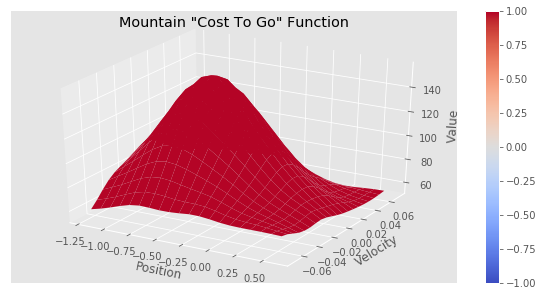

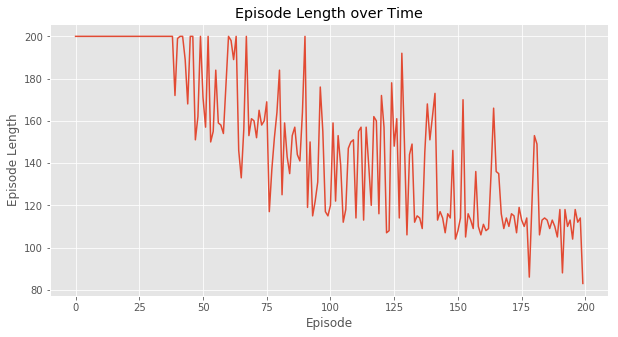

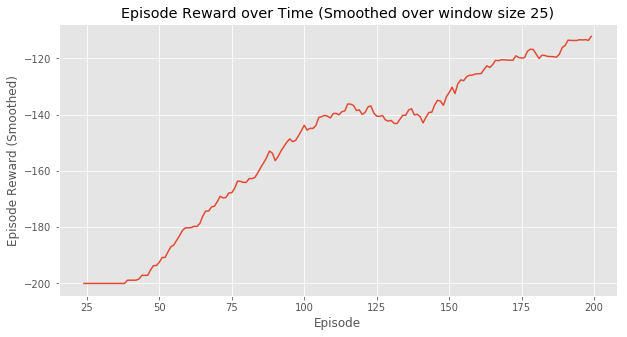

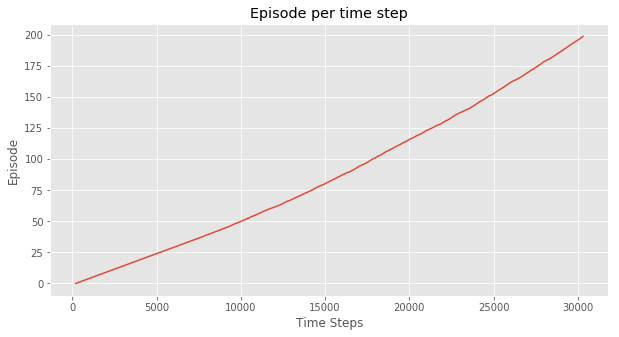

(<matplotlib.figure.Figure at 0x7f482460de80>,
 <matplotlib.figure.Figure at 0x7f48249da198>)

In [47]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)